## Entropy Balance

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

In [108]:
class EntropyBalance(object):
    """
    EntropyBalance
    
    
    """
    def __init__(self, X, Treatment, n_moments=2, base_weight=None):
        # Check the input
        if np.sum((Treatment != 1) & (Treatment != 0)) > 0:
            raise Exception("Treatment indicator ('Treatment') must be a logical variable, TRUE (1) or FALSE (0)")
        if np.sum(Treatment) == 0:
            raise Exception("Treatment indicator ('Treatment') must contain both treatment and control observations")
            
        if np.sum(np.isnan(X)) > 0:
            raise Exception("X contains missing data")
        if np.sum(np.isnan(Treatment)) > 0:
            raise Exception("Treatment contains missing data")  
        
        if len(Treatment) != len(X):
            raise Exception("the examples not match between Treatment and X")
        
        if not isinstance(n_moments, int):
            raise Exception("the type of n_moments should be int")

        if base_weight is None:
            n_weight = (Treatment[:,-1]==0).sum()
            self.base_weight = np.repeat(1/n_weight, n_weight).reshape(-1,1)
        elif len(base_weight) != len(X):
            raise Exception("the length of base_weight not match the length of X")
        else:
            self.base_weight = base_weight
        
        # Set up parameters
        self.X = np.array(X)
        self.Treatment = Treatment.astype(int)
        self.n_moments = n_moments
        
        # get moments of X
        self.C, self.targets = self.get_moments()
    
    def get_moments(self):
        poly_n = PolynomialFeatures(degree=self.n_moments)
        X_moments = poly_n.fit_transform(self.X)
        data = np.concatenate((X_moments, self.Treatment), axis=1)
        C = data[data[:,-1]==0, :-1].T
        targets = data[data[:,-1]==1, :-1].mean(axis=0).reshape(-1,1)
        return C, targets

    def fit(self, max_iters=10000, optim_method='L-BFGS-B', bal_tol=0.0001, verbose=0):
        if not isinstance(max_iters, int):
            raise Exception("the type of max_iters should be int")
        if optim_method not in ('L-BFGS-B', 'BFGS'):
            raise Exception("the max_iters should be 'L-BFGS-B' or 'L-BFGS-B'")
        if not isinstance(bal_tol, (int, float)):
            raise Exception("the type of bal_tol should be int")
        if not isinstance(verbose, int):
            raise Exception("the type of verbose should be int")
        
        C = self.C
        M = self.targets
        Q = self.base_weight

        z_init = np.linalg.inv(C @ C.T + np.eye(C.shape[0])) @ M

        if optim_method == 'L-BFGS-B':
            opt_val = minimize(fun=self.loss_func, x0=z_init, args=(Q, C, M), method='L-BFGS-B', jac=self.grad_func, 
                               tol=bal_tol, options={'maxiter': max_iters})
        elif optim_method == 'BFGS':
            opt_val = minimize(fun=self.loss_func, x0=z_init, args=(Q, C, M), method='BFGS', jac=self.grad_func, 
                               tol=bal_tol, options={'maxiter': max_iters})
        else:
            print('Unknown optimization method: Only L-BFGS-B and BFGS supported at this point')

        W = self.get_weights(opt_val.x.reshape(-1,1), Q, C)

        return opt_val.x, opt_val.fun, W

    def get_weights(self, Z, Q, C):
        Z = Z.reshape(-1,1)
        norm_c = Q.T @ np.exp(-C.T @ Z)
        W = Q * np.exp(-C.T @ Z) / norm_c
        return W

    def loss_func(self, Z, Q, C, M):
        Z = Z.reshape(-1,1)
        loss = np.sum(np.log(Q.T @ np.exp(-C.T @ Z)) + M.T @ Z)
        return loss

    def grad_func(self, Z, Q, C, M):
        Z = Z.reshape(-1,1)
        W = self.get_weights(Z, Q, C)
        grad = (M - C @ W)
        grad = np.squeeze(grad)
        return grad

    def hess_func(self, Z, Q, C, M):
        Z = Z.reshape(-1,1)
        W = self.get_weights(Z, Q, C)
        DW = W * np.eye(W.shape[0])
        hess = C @ (DW - W @ W.T) @ C.T
        return hess

### 1、读取数据

In [126]:
data = pd.read_excel('./data/tra_sample.xlsx')  
data.head()  
feature_lst = ['zx_score','msg_cnt','phone_num_cnt','register_days']    
train = data[data.type == 'target'].reset_index().copy()    
diff = data[data.type == 'origin'].reset_index().copy()    
val = data[data.type == 'offtime'].reset_index().copy()   

''' 
TrainS 目标域样本   
TrainA 源域样本   
LabelS 目标域标签   
LabelA 源域标签   
'''  
  
train = train.loc[:1200]    
    
trans_S = train[feature_lst].copy()    
label_S = train['bad_ind'].copy()   
treatment_S = np.ones(trans_S.shape[0])

trans_A = diff[feature_lst].copy()    
label_A = diff['bad_ind'].copy()    
treatment_A = np.zeros(trans_A.shape[0])
    
val_x =  val[feature_lst].copy()    
val_y = val['bad_ind'].copy()    

test = val_x.copy()  

### 2、EntropyBalance

In [110]:
X = np.concatenate((trans_A, trans_S), axis=0)  
Treatment = np.concatenate((treatment_A, treatment_S), axis=0).reshape(-1,1)

In [115]:
EB = EntropyBalance(X, Treatment, n_moments=2)

In [116]:
x, fun, W = EB.fit()

**比较熵均衡后协变量的均值**

In [179]:
ES = trans_S.mean(axis=0)
EA = trans_A.mean(axis=0)
EA_eb = (np.repeat(W, 4, axis=1)*(trans_A.values)).sum(axis=0)

print('实验组数据协变量的均值为：', ES.values)
print('对照组数据原始协变量的均值为：', EA.values)
print('对照组数据熵均衡后协变量的方差为：', EA_eb)

实验组数据协变量的均值为： [-0.07314634  0.04416954  0.08789342  0.17699994]
对照组数据原始协变量的均值为： [-0.09064679  0.03343301  0.0559981   0.25025325]
对照组数据熵均衡后协变量的方差为： [-0.07256251  0.04437793  0.08749817  0.17670032]


**比较熵均衡后协变量的方差**

In [180]:
DS = ((trans_S.values - ES.values)**2).mean(axis=0)
DA = ((trans_A.values - EA.values)**2).mean(axis=0)
DA_eb = (np.repeat(W, 4, axis=1)*((trans_A.values - EA_eb)**2)).sum(axis=0)

print('实验组数据协变量的方差为：', DS)
print('对照组数据原始协变量的方差为：', DA)
print('实验组数据熵均衡后协变量的方差为：', DA_eb)

实验组数据协变量的方差为： [0.02442526 0.00300429 0.02578982 0.02402252]
对照组数据原始协变量的方差为： [0.02439001 0.00114056 0.01775741 0.02390774]
实验组数据熵均衡后协变量的方差为： [0.02445463 0.0032251  0.02560035 0.02414573]


熵均衡结论：

匹配前协变量在一阶矩和二阶矩上均有一定差异，经熵均衡法匹配后，实验组和对照组协变量的均值、方差基本一致。

### 3、EB用于迁移学习

In [153]:
lr_model = LogisticRegression(C=0.1, class_weight = 'balanced', solver = 'liblinear')  
lr_model.fit(trans_S, label_S)  
  
y_pred = lr_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  

train_ks :  0.48500238435860754


In [159]:
# trans_A_W = np.repeat(W, 4, axis=1)*(trans_A.values)
trans_A_pred = lr_model.predict_proba(trans_A_W)[:,1]

In [161]:
trans_A_pred.min()

0.44080975424121827

## TrAdaBoost

### 1、LR

#### 1.1 LR with target

In [103]:
import numpy as np      
import pandas as pd    
from matplotlib import pyplot as plt  
from sklearn.linear_model import LogisticRegression     
from sklearn.metrics import roc_curve  

train_ks :  0.48500238435860754
val_ks :  0.3887057754389137


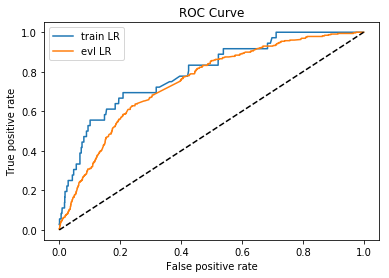

In [104]:
lr_model = LogisticRegression(C=0.1, class_weight = 'balanced', solver = 'liblinear')  
lr_model.fit(trans_S,label_S)  
  
y_pred = lr_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = lr_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
   
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  

#### 1.2 LR with origin

train_ks :  0.5708392942298521
val_ks :  0.3306222886955654


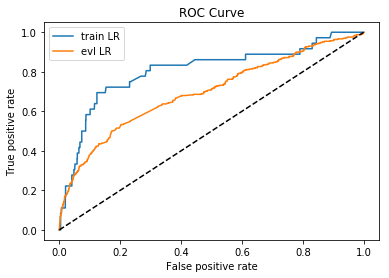

In [127]:
lr_model = LogisticRegression(C=0.1, class_weight = 'balanced', solver = 'liblinear')  
lr_model.fit(trans_A,label_A)  
  
y_pred = lr_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = lr_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
   
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  

#### 1.2 LR with origin and weight

train_ks :  0.3366714353838818
val_ks :  0.23084784428402855


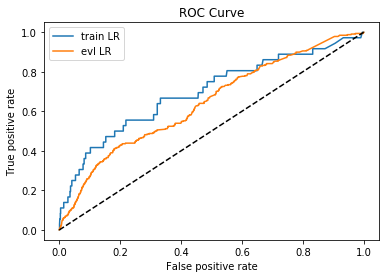

In [152]:
lr_model = LogisticRegression(C=0.1, class_weight = 'balanced', solver = 'liblinear')  
lr_model.fit(trans_A,label_A, sample_weight=np.squeeze(W))  
  
y_pred = lr_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = lr_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
   
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  

#### 1.3 LR with origin and target

train_ks :  0.4906545032403352
val_ks :  0.33077621830414


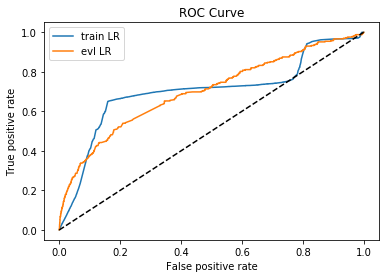

In [105]:
trans_data = np.concatenate((trans_A, trans_S), axis=0)  
trans_label = np.concatenate((label_A, label_S), axis=0)  
  
lr_model = LogisticRegression(C=0.3,class_weight = 'balanced',solver = 'liblinear')  
lr_model.fit(trans_data,trans_label)  
  
y_pred = lr_model.predict_proba(trans_data)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(trans_label,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = lr_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
  
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  

###  2、Tr_lr_boost

In [106]:
def Tr_lr_boost(trans_A,trans_S,label_A,label_S,test,label_test,
                  N=500,early_stopping_rounds =100):    
    """   
        逻辑回归的学习率、权重的大小，影响整体收敛的快慢    
        H 测试样本分类结果    
        TrainS 目标域样本    
        TrainA 源域样本    
        LabelS 目标域标签    
        LabelA 源域标签    
        Test  测试样本    
        N 迭代次数   
        early_stopping_rounds 提前停止轮次 
    """   
    #计算weight      
    def calculate_P(weights, label):      
        total = np.sum(weights)      
        return np.asarray(weights / total, order='C')      
          
    #用逻辑回归作为基分类器，输出概率      
    def train_classify(trans_data, trans_label, test_data, P):      
        clf = LogisticRegression(C=0.3,class_weight = 'balanced',solver='liblinear')      
        clf.fit(trans_data, trans_label, sample_weight=P[:, 0])      
        return clf.predict_proba(test_data)[:,1],clf      
          
    #计算在目标域上面的错误率      
    def calculate_error_rate(label_R, label_H, weight):      
        total = np.sum(weight)      
        return np.sum(weight[:, 0] / total * np.abs(label_R - label_H))      
          
    #根据逻辑回归输出的score的得到标签，注意这里不能用predict直接输出标签      
    def put_label(score_H,thred):      
        new_label_H = []      
        for i in score_H:      
            if i <= thred:      
                new_label_H.append(0)      
            else:      
                new_label_H.append(1)      
        return new_label_H      
          
    #指定迭代次数，相当于集成模型中基模型的数量      
         
          
    #拼接数据集    
    trans_data = np.concatenate((trans_A, trans_S), axis=0)      
    trans_label = np.concatenate((label_A, label_S), axis=0)      
        
    #三个数据集样本数    
    row_A = trans_A.shape[0]      
    row_S = trans_S.shape[0]      
    row_T = test.shape[0]      
        
    #三个数据集合并为打分数据集    
    test_data = np.concatenate((trans_data, test), axis=0)      
          
    # 初始化权重      
    weights_A = np.ones([row_A, 1])/row_A      
    weights_S = np.ones([row_S, 1])/row_S*2      
    weights = np.concatenate((weights_A, weights_S), axis=0)      
        
    #按照公式初始化beta值    
    bata = 1 / (1 + np.sqrt(2 * np.log(row_A / N)))      
          
        
    # 存每一次迭代的bata值=error_rate / (1 - error_rate)      
    bata_T = np.zeros([1, N])      
    # 存储每次迭代的标签    
    result_label = np.ones([row_A + row_S + row_T, N])       
          
    trans_data = np.asarray(trans_data, order='C')      
    trans_label = np.asarray(trans_label, order='C')      
    test_data = np.asarray(test_data, order='C')      
        
    #最优KS      
    best_ks = -1      
    #最优基模型数量          
    best_round = -1    
    #最优模型      
    best_model = -1     
         
    """ 
    初始化结束    
    正式开始训练  
    """     
        
    for i in range(N):      
        P = calculate_P(weights, trans_label)      
          
        result_label[:, i],model = train_classify(trans_data, trans_label, test_data, P)  
        score_H = result_label[row_A:row_A + row_S, i]      
        pctg = np.sum(trans_label)/len(trans_label)      
        thred = pd.DataFrame(score_H).quantile(1-pctg)[0]      
        
        label_H = put_label(score_H,thred)      
        
        #计算在目标域上的错误率    
        error_rate = calculate_error_rate(label_S, label_H,   
                                                    weights[row_A:row_A + row_S, :])  
        # 防止过拟合     
        if error_rate > 0.5:      
            error_rate = 0.5      
        if error_rate == 0:      
            N = i      
            break       
                
        bata_T[0, i] = error_rate / (1 - error_rate)      
          
        # 调整目标域样本权重      
        for j in range(row_S):      
            weights[row_A + j] = weights[row_A + j] * np.power(bata_T[0, i],  \
                                      (-np.abs(result_label[row_A + j, i] - label_S[j])))
          
        # 调整源域样本权重      
        for j in range(row_A):      
            weights[j] = weights[j] * np.power(bata,   
                                               np.abs(result_label[j, i] - label_A[j]))  
        y_pred = result_label[(row_A + row_S):,i]      
        fpr_lr_train,tpr_lr_train,_ = roc_curve(label_test,y_pred)      
        train_ks = abs(fpr_lr_train - tpr_lr_train).max()      
        print('test_ks : ',train_ks,'当前第',i+1,'轮')      
              
        # 不再使用后一半学习器投票，而是只保留效果最好的逻辑回归模型      
        if train_ks > best_ks :      
            best_ks = train_ks      
            best_round = i      
            best_model = model    
        # 当超过eadrly_stopping_rounds轮KS不再提升后，停止训练  
        if best_round < i - early_stopping_rounds:  
            break  
    return best_ks,best_round,best_model   

test_ks :  0.15578884442899515 当前第 1 轮
test_ks :  0.1456766433836767 当前第 2 轮
test_ks :  0.15245383280828395 当前第 3 轮
test_ks :  0.1538220526961453 当前第 4 轮
test_ks :  0.15731820328684526 当前第 5 轮
test_ks :  0.16959710970855468 当前第 6 轮
test_ks :  0.18271931656812573 当前第 7 轮
test_ks :  0.1904785379259174 当前第 8 轮
test_ks :  0.19334006986455754 当前第 9 轮
test_ks :  0.1984978808374394 当前第 10 轮
test_ks :  0.20559364609751418 当前第 11 轮
test_ks :  0.21212143058670957 当前第 12 轮
test_ks :  0.22506457249655903 当前第 13 轮
test_ks :  0.22742924304043327 当前第 14 轮
test_ks :  0.22872634355218102 当前第 15 轮
test_ks :  0.22797832359355108 当前第 16 轮
test_ks :  0.2292259328134279 当前第 17 轮
test_ks :  0.23506980220629836 当前第 18 轮
test_ks :  0.23897552246437015 当前第 19 轮
test_ks :  0.2410845529494472 当前第 20 轮
test_ks :  0.24680118685573632 当前第 21 轮
test_ks :  0.24793519992143745 当前第 22 轮
test_ks :  0.24992381458613588 当前第 23 轮
test_ks :  0.25544599058184614 当前第 24 轮
test_ks :  0.26158856135439346 当前第 25 轮
test_ks :  0.25

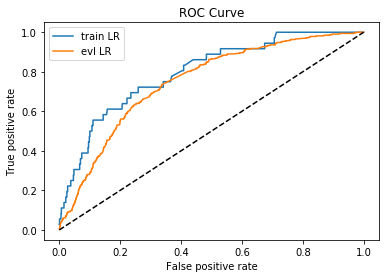

In [107]:
# 训练并得到最优模型best_model    
best_ks,best_round,best_model = Tr_lr_boost(trans_A,trans_S,label_A,label_S,
                                            test,label_test=val_y,N=300,
                                            early_stopping_rounds=20) 

y_pred = best_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = best_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
  
from matplotlib import pyplot as plt  
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  

In [139]:
def Tr_lr_boost(trans_A,trans_S,label_A,label_S,test,label_test, weights_A,
                  N=500,early_stopping_rounds =100):    
    """   
        逻辑回归的学习率、权重的大小，影响整体收敛的快慢    
        H 测试样本分类结果    
        TrainS 目标域样本    
        TrainA 源域样本    
        LabelS 目标域标签    
        LabelA 源域标签    
        Test  测试样本    
        N 迭代次数   
        early_stopping_rounds 提前停止轮次 
    """   
    #计算weight      
    def calculate_P(weights, label):      
        total = np.sum(weights)      
        return np.asarray(weights / total, order='C')      
          
    #用逻辑回归作为基分类器，输出概率      
    def train_classify(trans_data, trans_label, test_data, P):      
        clf = LogisticRegression(C=0.3,class_weight = 'balanced',solver='liblinear')      
        clf.fit(trans_data, trans_label, sample_weight=P[:, 0])      
        return clf.predict_proba(test_data)[:,1],clf      
          
    #计算在目标域上面的错误率      
    def calculate_error_rate(label_R, label_H, weight):      
        total = np.sum(weight)      
        return np.sum(weight[:, 0] / total * np.abs(label_R - label_H))      
          
    #根据逻辑回归输出的score的得到标签，注意这里不能用predict直接输出标签      
    def put_label(score_H,thred):      
        new_label_H = []      
        for i in score_H:      
            if i <= thred:      
                new_label_H.append(0)      
            else:      
                new_label_H.append(1)      
        return new_label_H      
          
    #指定迭代次数，相当于集成模型中基模型的数量      
         
          
    #拼接数据集    
    trans_data = np.concatenate((trans_A, trans_S), axis=0)      
    trans_label = np.concatenate((label_A, label_S), axis=0)      
        
    #三个数据集样本数    
    row_A = trans_A.shape[0]      
    row_S = trans_S.shape[0]      
    row_T = test.shape[0]      
        
    #三个数据集合并为打分数据集    
    test_data = np.concatenate((trans_data, test), axis=0)      
          
    # 初始化权重      
    weights_A = weights_A    
    weights_S = np.ones([row_S, 1])/row_S*2      
    weights = np.concatenate((weights_A, weights_S), axis=0)      
        
    #按照公式初始化beta值    
    bata = 1 / (1 + np.sqrt(2 * np.log(row_A / N)))      
          
        
    # 存每一次迭代的bata值=error_rate / (1 - error_rate)      
    bata_T = np.zeros([1, N])      
    # 存储每次迭代的标签    
    result_label = np.ones([row_A + row_S + row_T, N])       
          
    trans_data = np.asarray(trans_data, order='C')      
    trans_label = np.asarray(trans_label, order='C')      
    test_data = np.asarray(test_data, order='C')      
        
    #最优KS      
    best_ks = -1      
    #最优基模型数量          
    best_round = -1    
    #最优模型      
    best_model = -1     
         
    """ 
    初始化结束    
    正式开始训练  
    """     
        
    for i in range(N):      
        P = calculate_P(weights, trans_label)      
          
        result_label[:, i],model = train_classify(trans_data, trans_label, test_data, P)  
        score_H = result_label[row_A:row_A + row_S, i]      
        pctg = np.sum(trans_label)/len(trans_label)      
        thred = pd.DataFrame(score_H).quantile(1-pctg)[0]      
        
        label_H = put_label(score_H,thred)      
        
        #计算在目标域上的错误率    
        error_rate = calculate_error_rate(label_S, label_H,   
                                                    weights[row_A:row_A + row_S, :])  
        # 防止过拟合     
        if error_rate > 0.5:      
            error_rate = 0.5      
        if error_rate == 0:      
            N = i      
            break       
                
        bata_T[0, i] = error_rate / (1 - error_rate)      
          
        # 调整目标域样本权重      
        for j in range(row_S):      
            weights[row_A + j] = weights[row_A + j] * np.power(bata_T[0, i],  \
                                      (-np.abs(result_label[row_A + j, i] - label_S[j])))
          
        # 调整源域样本权重      
        for j in range(row_A):      
            weights[j] = weights[j] * np.power(bata,   
                                               np.abs(result_label[j, i] - label_A[j]))  
        y_pred = result_label[(row_A + row_S):,i]      
        fpr_lr_train,tpr_lr_train,_ = roc_curve(label_test,y_pred)      
        train_ks = abs(fpr_lr_train - tpr_lr_train).max()      
        print('test_ks : ',train_ks,'当前第',i+1,'轮')      
              
        # 不再使用后一半学习器投票，而是只保留效果最好的逻辑回归模型      
        if train_ks > best_ks :      
            best_ks = train_ks      
            best_round = i      
            best_model = model    
        # 当超过eadrly_stopping_rounds轮KS不再提升后，停止训练  
        if best_round < i - early_stopping_rounds:  
            break  
    return best_ks,best_round,best_model   

test_ks :  0.23136555437261414 当前第 1 轮
test_ks :  0.15699144385193453 当前第 2 轮
test_ks :  0.15168691263189232 当前第 3 轮
test_ks :  0.15130345254369648 当前第 4 轮
test_ks :  0.1557393531371244 当前第 5 轮
test_ks :  0.1663493898152376 当前第 6 轮
test_ks :  0.17460820043427627 当前第 7 轮
test_ks :  0.1905424479406167 当前第 8 轮
test_ks :  0.1932077683402258 当前第 9 轮
test_ks :  0.1972313713998008 当前第 10 轮
test_ks :  0.20399589573003157 当前第 11 轮
test_ks :  0.20832287651182252 当前第 12 轮
test_ks :  0.22011739178553674 当前第 13 轮
test_ks :  0.22762097308453116 当前第 14 轮
test_ks :  0.2283239832462235 当前第 15 轮
test_ks :  0.2288730637993413 当前第 16 轮
test_ks :  0.22928263346671307 当前第 17 轮
test_ks :  0.23196432106520848 当前第 18 轮
test_ks :  0.23513371222099766 当前第 19 轮
test_ks :  0.24032289365841186 当前第 20 轮
test_ks :  0.2449666966472182 当前第 21 轮
test_ks :  0.24857430006843048 当前第 22 轮
test_ks :  0.24960426451263934 当前第 23 轮
test_ks :  0.2542696955856885 当前第 24 轮
test_ks :  0.25943452107237885 当前第 25 轮
test_ks :  0.25973

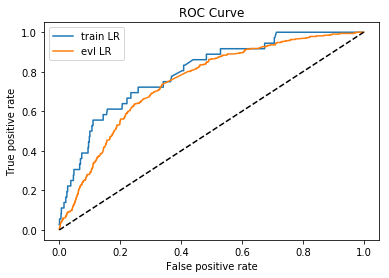

In [140]:
# 训练并得到最优模型best_model    
best_ks,best_round,best_model = Tr_lr_boost(trans_A,trans_S,label_A,label_S,
                                            test,label_test=val_y,weights_A=W,
                                            N=300,early_stopping_rounds=20) 

y_pred = best_model.predict_proba(trans_S)[:,1]  
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_S,y_pred)  
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  
print('train_ks : ',train_ks)  
  
y_pred = best_model.predict_proba(test)[:,1]  
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)  
val_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',val_ks)  
  
from matplotlib import pyplot as plt  
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')  
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()  